In [294]:
import numpy as np
import seaborn as sns
import sympy as sp
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(1)

In [ ]:
# Sample latent variable, noise -> generate data
n = 100
z = np.random.normal(size=(n, 1))
print(z.shape)
s = 0.1
eps = np.random.normal(loc=0, scale=s**2, size=(n, 2))  # PPCA because it is isotropic
print(eps.shape)

# Generative model
x = np.einsum('ij,nj->ni', W, z) + mu + eps
print(x.shape)
# Plot data
plt.scatter(x[:, 0], x[:, 1])
plt.axis('equal')

In [ ]:
# Mixture of FA / PPCA
# Models parameters

W = np.array([
    [[2], [3]],  # W1
    [[-1], [1]],  # W2
    [[2], [1]]  # W3
])

mu = np.array([
    [2, 3],  # mu1
    [-1, 1],  # mu2
    [2, 1]  # mu3
])

probabilities = np.array([0.1, 0.6, 0.3])
# Sample latent variable, noise -> generate data
n = 1000
z = np.random.normal(size=(n, 1))
s = 0.1
eps = np.random.normal(loc=0, scale=s**2, size=(n, 2))  # PPCA because it is isotropic

# Generative model
c = np.random.choice([0, 1, 2], n, p=probabilities)

mask = np.zeros((n, 3))
for i in range(n): 
    mask[i] = c[i] == range(3)
ws = np.einsum('nm, mij->nij', mask, W)
mus = np.einsum('nm, mi->ni', mask, mu)
x = np.einsum('nij,nj->ni', ws, z) 
x = x + mus + eps

# Plot data
plt.scatter(x[:, 0], x[:, 1])
plt.axis('equal')

## Generating synthetic data from 2D model: x = W^T z + mu + eps

In [ ]:
# Models parameters
w1 = 2
w2 = 3
W = np.array([[w1], [w2]])
mu1 = -1
mu2 = 1
mu = np.array([mu1, mu2])
print(mu.shape)

# Sample latent variable, noise -> generate data
n = 100
z = np.random.normal(size=(n, 1))
print(z.shape)
s = 0.1
eps = np.random.normal(loc=0, scale=s**2, size=(n, 2))  # PPCA because it is isotropic
print(eps.shape)

# Generative model
x = np.einsum('ij,nj->ni', W, z) + mu + eps
x = np.maximum(x, 0)  # ReLu 
print(x.shape)
# Plot data
plt.scatter(x[:, 0], x[:, 1])
plt.axis('equal')

# Adding a second layer
v1 = -4
v2 = 7
V = np.array([[v1], [v2]])
m1 = 3
m2 = 5
m = np.array([m1, m2])
print(mu.shape)

# Generative model
h = np.einsum('ij,nj->ni', W, z) + mu
h = np.maximum(h, 0)  # ReLu 
eps = np.random.normal(loc=0, scale=s**2, size=(n, 2))  # PPCA because it is isotropic
x = np.einsum('ij,nj->ni', V, h) + m + eps
x = np.maximum(x, 0)  # ReLu 
print(x.shape)
# Plot data
plt.figure()
plt.scatter(x[:, 0], x[:, 1])
plt.axis('equal')

## Building 2D VAE to fit the synthetic 2D data

d1.weight tensor([[1.],
        [1.]], device='cuda:0') 

d1.bias tensor([ 0., -1.], device='cuda:0') 

dfc.weight tensor([[1., 1.],
        [2., 2.]], device='cuda:0') 

dfc.bias tensor([0., 0.], device='cuda:0') 



<Figure size 432x288 with 0 Axes>

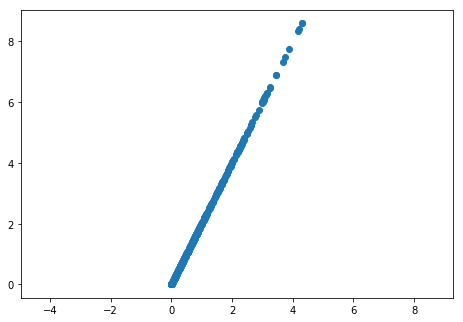

In [283]:
import toynn
import importlib
importlib.reload(toynn)

import torch
import torch.nn as tnn
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

DEVICE = 'cuda'

data_dim = 2
latent_dim = 1
n_layers = 2

decoder = toynn.Decoder(
    latent_dim=latent_dim, data_dim=data_dim, n_layers=n_layers)
decoder.to(DEVICE)

decoder.d1.weight.data = torch.tensor([[1.], [1.]]).to(DEVICE)
decoder.d1.bias.data = torch.tensor([0., -1.]).to(DEVICE)

decoder.layers[0].weight.data = torch.tensor([[1., 1.], [2., 2.]]).to(DEVICE)
decoder.layers[0].bias.data = torch.tensor([0., 0.]).to(DEVICE)

for name, param in decoder.named_parameters():
    print(name, param.data, '\n')
    
x = decoder.generate(n_samples=1000)

x = x.cpu().detach().numpy()

plt.figure()
fig = plt.figure()
ax = fig.add_axes([-1, 1, 1, 1])
ax.scatter(x[:, 0], x[:, 1])

chut = plt.axis('equal')

# Optimization investigation: 1D

## Generating synthetic data from 1D model: x = wz + eps

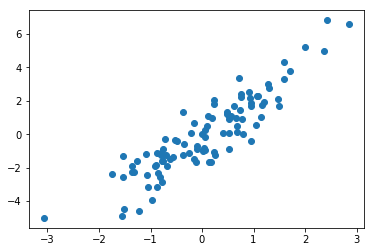

In [492]:
w_true = 2
def generate_synthetic_1d(w=w_true, n=10):
    # Sample latent variable, noise -> generate data
    z = np.random.normal(loc=0, scale=1, size=(n, 1))
    eps = np.random.normal(loc=0, scale=1, size=(n, 1))  # PPCA because it is isotropic

    # Generative model
    x = w * z + eps
    return z, x

z, x = generate_synthetic_1d(n=100)
plt.plot(z, x, 'o')

## Enter loglikelihood and other objectives, solve for extrema. 
Note q(z|x) = N(phi x, 1)

In [383]:
sigma2 = np.mean(x**2)
w, phi, sig2 = sp.symbols('w, phi, sig2')

loglikelihood = - 1. / 2. * sp.log(2 * sp.pi * (w ** 2 + 1)) - sig2 / (2 * (w ** 2 + 1))
uvae = - 1. / 2. * sp.log(2 * sp.pi) - sig2 / 2. - w ** 2 / 2  + (w * phi + w ** 2 * phi ** 2 / 2) * sig2
klprior = 1. /2. * (phi ** 2 * sig2 ** 2)
klposterior = - 1. / 2. - 1. / 2. * sp.log(w ** 2) + 1. /2. * w ** 2 + 1. / 2. * (1 - phi * w) ** 2 * sig2
elbo = loglikelihood - klposterior
elbo_from_uvae = uvae - klprior

# Compute the differential of elbo with respect to w
expr = elbo
expr = expr.subs(sig2, sigma2)
dexpr_w = sp.diff(expr, w)
#dexpr_w = sp.simplify(dexpr_w)
print('The differential of ELBO with respect to w is: \ndelbo / dw = ', dexpr_w)
print('\n')

def argmaxima_likelihood(expr=loglikelihood, x=None):
    if x is not None:
        sigma2 = np.mean(x**2)
        expr = expr.subs(sig2, sigma2)
    dexpr_w = sp.diff(expr, w)
    dexpr_w = sp.simplify(dexpr_w)
    argmaxima = sp.solve(dexpr_w, w)
    return argmaxima

def maxima_likelihood(expr=loglikelihood, x=None):
    if x is not None:
        sigma2 = np.mean(x**2)
        expr = expr.subs(sig2, sigma2)
    argmaxima = argmaxima_likelihood(expr, x)
    maxima = [expr.subs(w, argmax) for argmax in argmaxima]
    maxima = [sp.N(sp.simplify(maximum)) for maximum in maxima]
    return maxima

def argmaxima_w(expr=uvae, x=None):
    if x is not None:
        sigma2 = np.mean(x**2)
        expr = expr.subs(sig2, sigma2)
    dexpr_w = sp.diff(expr, w)
    dexpr_w = sp.simplify(dexpr_w)
    argmaxima = sp.solve(dexpr_w, w)
    return argmaxima

def argmaxima_phi(expr=uvae, x=None):
    if x is not None:
        sigma2 = np.mean(x**2)
        expr = expr.subs(sig2, sigma2)
    dexpr_phi = sp.diff(expr, phi)
    dexpr_phi = sp.simplify(dexpr_phi)
    argmaxima = sp.solve(dexpr_phi, phi)
    return argmaxima

print('The parameter w maximizing the log likelihood is: \nw = ', argmaxima_likelihood())
print('The value of the log likelihood at maximum is:')
print(maxima_likelihood())
print('\n')


print('For phi fixed, the parameter w maximizing ELBO is: w = ', argmaxima_w(expr=elbo))
print('For w fixed, the argument phi maximizing ELBO is: phi = ', argmaxima_phi(expr=elbo))

The differential of ELBO with respect to w is: 
delbo / dw =  6.58797175996372*phi*(-phi*w + 1) - 1.0*w + 26.3518870398549*w/(2*w**2 + 2)**2 - 1.0*w/(w**2 + 1) + 1.0/w


The parameter w maximizing the log likelihood is: 
w =  [0.0, -sqrt(sig2 - 1.0), sqrt(sig2 - 1.0)]
The value of the log likelihood at maximum is:
[-0.5*sig2 - 0.918938533204673, -0.5*log(2*pi*sig2) - 0.5, -0.5*log(2*pi*sig2) - 0.5]


For phi fixed, the parameter w maximizing ELBO is: w =  []
For w fixed, the argument phi maximizing ELBO is: phi =  [1/w]


In [391]:
def plot_landscape(ax, expr, x, u=np.linspace(-5, 5, 100), v=np.linspace(-1.2, 1.2, 100), cmap='Purples', minima=False):
    sigma2 = np.mean(x**2)

    uu, vv = numpy.meshgrid(u, v)
    
    if not phi in expr.free_symbols:
        f = sp.utilities.lambdify(w, expr.subs(sig2, sigma2), 'numpy')
        c = ax.contourf(uu, vv, f(uu), cmap=cmap, levels=100)
    else:
        f = sp.utilities.lambdify((w, phi), expr.subs(sig2, sigma2), 'numpy')
        c = ax.contourf(uu, vv, f(uu, vv), cmap=cmap, levels=100)

    plt.colorbar(c, ax=ax)
    
    ax.set_xlabel('w')
    ax.set_ylabel('phi')
    
    ax.set_xlim((np.min(u), np.max(u))) 
    ax.set_ylim((np.min(v), np.max(v))) 
    
    w_ml = argmaxima_likelihood(x=x)
    ws_true = np.array([w_true, -w_true])
    for w_elmt in ws_true:
        ax.axvline(w_elmt, color='green', linewidth=3)
        
    for w_elmt in w_ml:
        ax.axvline(w_elmt, color='blue', linewidth=3)

    
    
    if minima:
        #arg_w_of_phi = argmaxima_w(expr=elbo, x=x)
        #ws = [arg_w_of_phi[0].subs(phi, v_elmt) for v_elmt in v]
        #ax.plot(ws, v, color='grey', linewidth=3)
    
        arg_phi_of_w = argmaxima_phi(expr=elbo, x=x)
        phis = [arg_phi_of_w[0].subs(w, u_elmt) for u_elmt in u]
        ax.plot(u, phis, color='black', linewidth=1) 
  # set the ylim to bottom, top
    
    ax.grid()
    return ax

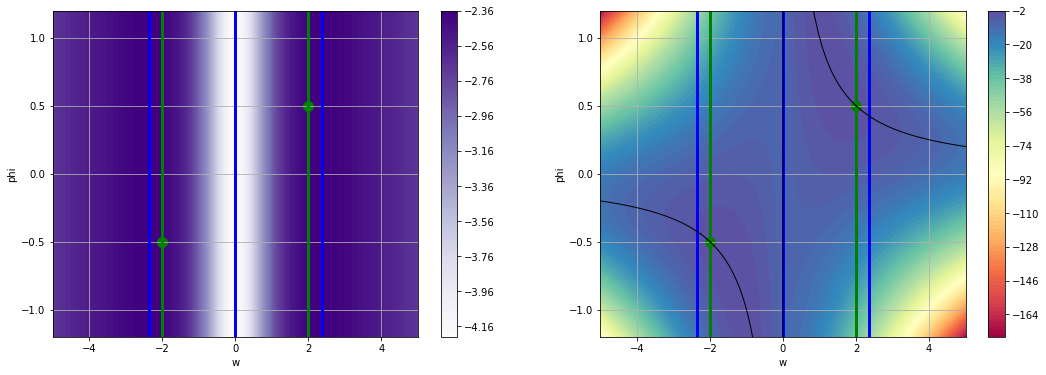

In [392]:
# Plot with the unidentifiability
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
ax = plot_landscape(axes[0], loglikelihood, x)

true_optimal_solutions = (2, 1./ 2.)
ax.scatter([2, -2], [0.5, -0.5], color='green', s=100)


ax = plot_landscape(axes[1], elbo, x, cmap='Spectral', minima=True)
ax.scatter([2, -2], [0.5, -0.5], color='green', s=100)

In [490]:
def get_arg_maximum(expr, x, u=np.linspace(-5, 5, 100), v=np.linspace(-1.2, 1.2, 100)):
    sigma2 = np.mean(x**2)

    uu, vv = numpy.meshgrid(u, v)
    
    if not phi in expr.free_symbols:
        f = sp.utilities.lambdify(w, expr.subs(sig2, sigma2), 'numpy')
        f_values = f(u)
        f_max = np.max(f_values)
        u_id_argmax = np.where(f(u) == f_max)
        u_argmax = u[u_id_argmax]
        return u_argmax

    else:
        f = sp.utilities.lambdify((w, phi), expr.subs(sig2, sigma2), 'numpy')
        f_values = f(uu, vv)
        f_max = np.max(f_values)
        
        v_id_argmax, u_id_argmax = np.where(f(uu, vv) == f_max)
             
        u_argmax = u[u_id_argmax]
        v_argmax = v[v_id_argmax]
        return u_argmax, v_argmax


def plot_maximum(ax, expr, x, u=np.linspace(-5, 5, 100), v=np.linspace(-1.2, 1.2, 100)):
    if not phi in expr.free_symbols:
        u_argmax = get_arg_maximum(expr, x, u, v)
        ax.axvline(u_argmax, color='red', linewidth=3)

    else:
        u_argmax, v_argmax = get_arg_maximum(expr, x, u, v)
        ax.scatter(u_argmax, v_argmax, color='red', s=100)
        
    return ax

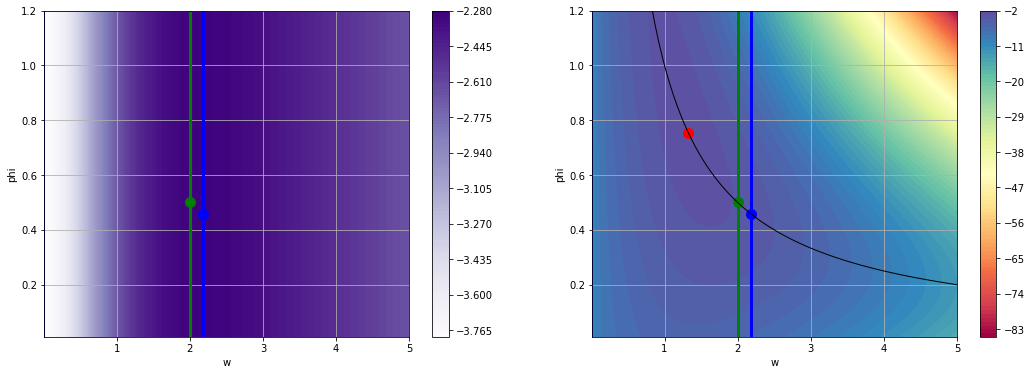

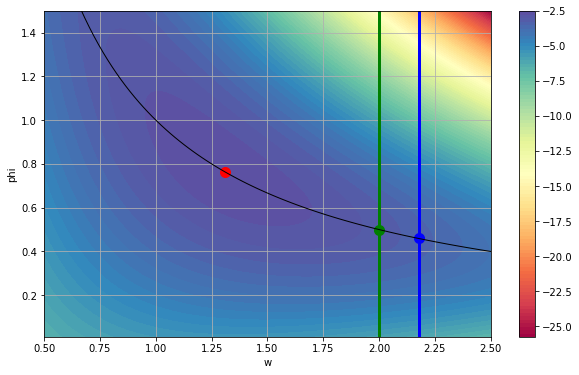

In [491]:
z, x = generate_synthetic_1d(n=10)

phi_optimal_expr = argmaxima_phi(expr=elbo)

def ws_and_phis(ws, phi_expr):
    n_optimal_phis = len(phi_expr)
    if n_optimal_phis > 1:
        ws = ws.repeat(ws, n_optimal_phis)
       
    phis = np.array([[phi_elmt.subs(w, w_elmt) for w_elmt in ws] 
                    for phi_elmt in phi_expr])
    return ws, phis
    
def plot_true_best(ax, w_true, x):
    w_true_solutions = np.array([w_true, -w_true])
    w_best_solutions = argmaxima_likelihood(x=x)

    ws_true, phis_true = ws_and_phis(w_true_solutions, phi_optimal_expr)
    ws_best, phis_best = ws_and_phis(w_best_solutions, phi_optimal_expr)
    ax.scatter(ws_true, phis_true, color='green', s=100)
    ax.scatter(ws_best, phis_best, color='blue', s=100)
    return ax

# One quadrant
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

u = np.linspace(0.01, 5, 100)
v = np.linspace(0.01, 1.2, 100)

ax = plot_landscape(axes[0], loglikelihood, x, u=u, v=v)
ax = plot_true_best(ax, w_true, x)

ax = plot_landscape(axes[1], elbo, x, u=u, v=v, cmap='Spectral', minima=True)
ax = plot_true_best(axes[1], w_true, x)
ax = plot_maximum(axes[1], elbo, x, u=u, v=v)

# Zoom
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
def plot_elbo_landscape(ax, x, w_true, u=np.linspace(0.5, 2.5, 100), v=np.linspace(0.01, 1.5, 100)):
    ax = plot_landscape(ax, elbo, x, u=u, v=v, cmap='Spectral', minima=True)
    ax = plot_true_best(ax, w_true, x)
    ax = plot_maximum(ax, elbo, x, u=u, v=v)
    return ax
    
ax = plot_elbo_landscape(axes, x, w_true)

Text(0.5, 1.0, 'n = 100')

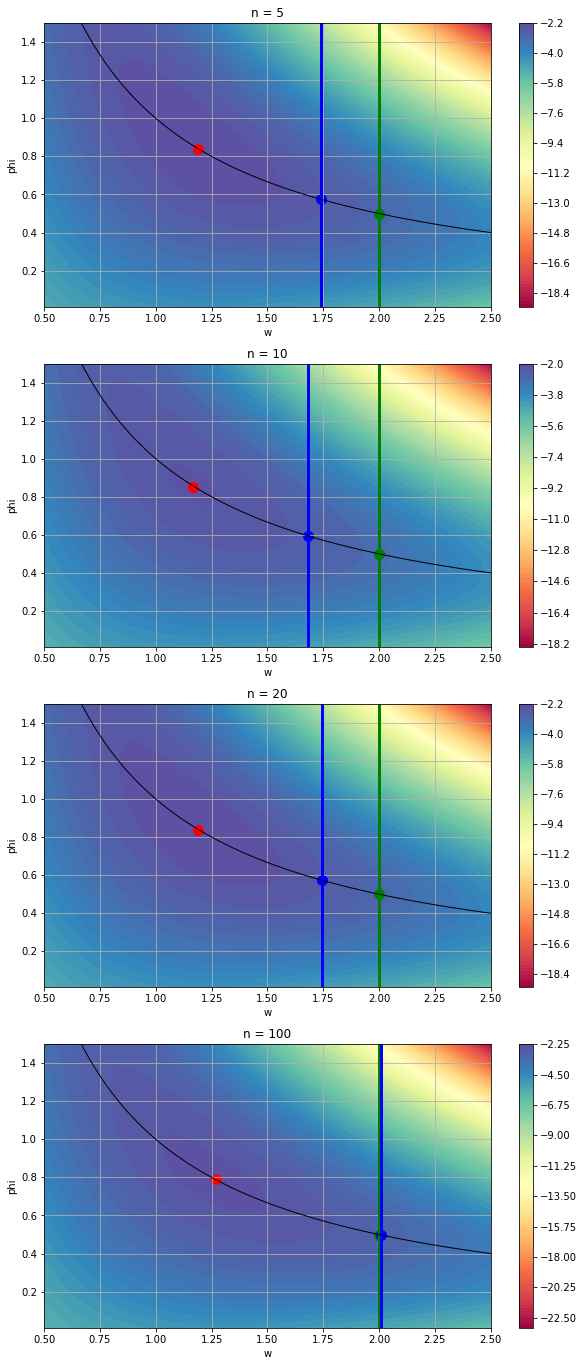

In [487]:
# Study of the ELBO landscape for different sample sizes n
fig, axes = plt.subplots(4, 1, figsize=(10, 24))

n = 5
z, x = generate_synthetic_1d(n=n)
ax = plot_elbo_landscape(axes[0], x, w_true)
ax.set_title('n = %d' % n)

n = 10
z, x = generate_synthetic_1d(n=n)
ax = plot_elbo_landscape(axes[1], x, w_true)
ax.set_title('n = %d' % n)

n = 20
z, x = generate_synthetic_1d(n=n)
ax = plot_elbo_landscape(axes[2], x, w_true)
ax.set_title('n = %d' % n)

n = 100
z, x = generate_synthetic_1d(n=n)
ax = plot_elbo_landscape(axes[3], x, w_true)
ax.set_title('n = %d' % n)

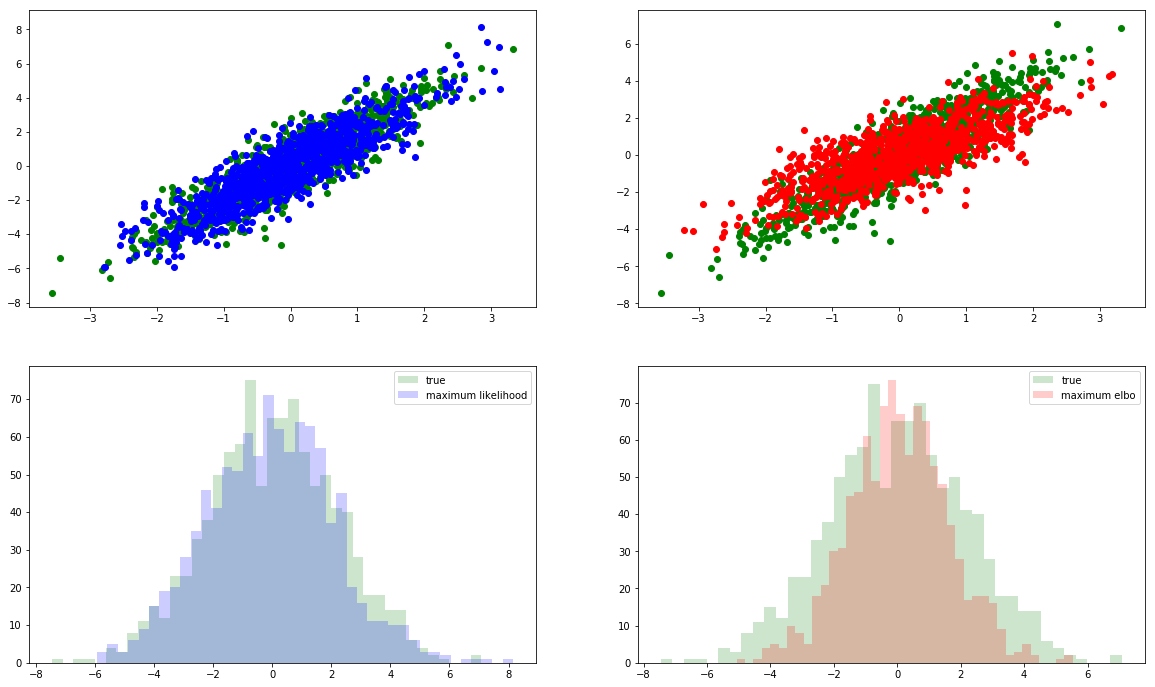

In [547]:
# Generate data with estimated w
n = 1000

z, x = generate_synthetic_1d(w=w_true, n=n)

u = np.linspace(0.01, 5, 100)
v = np.linspace(0.01, 1.2, 100)

w_ml = argmaxima_likelihood(x=x)
w_ml = w_ml[2] # Select positive solution
w_ml = np.array(w_ml).astype(np.float64)  # from sympy to numpy

w_argmax, phi_argmax = get_arg_maximum(elbo, x, u, v)  # argmax numerically
w_argmax = w_argmax[0]

z_ml, x_ml = generate_synthetic_1d(w=w_ml, n=n)
z_elbo, x_elbo = generate_synthetic_1d(w=w_argmax, n=n)

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

ax = axes[0, 0]
ax.scatter(z, x, color='green')
ax.scatter(z_ml, x_ml, color='blue')

ax = axes[0, 1]
ax.scatter(z, x, color='green')
ax.scatter(z_elbo, x_elbo, color='red')

ax = axes[1, 0]

alpha = 0.2
bins = 40
ax.hist(x, bins=bins, alpha=alpha, color='green', label='true')
ax.hist(x_ml, bins=bins, alpha=alpha, color='blue', label='maximum likelihood')
ax.legend(loc='upper right')

ax = axes[1, 1]
ax.hist(x, bins=bins, alpha=alpha, color='green', label='true')
ax.hist(x_elbo, bins=bins, alpha=alpha, color='red', label='maximum elbo')

ax.legend(loc='upper right')

# Note: This does not take into account the amortization error.
# TODOs:
# - Look at mutual information between x and z.

In [548]:
# TODOs:
# Look at the reconstruction distribution: 
# - if we distribute z with its posterior.
# - if we distribute z with the marginal of q


def generate_synthetic_1d_from_posterior(w=w_true, n=10, mu, sigma):
    # Sample latent variable, noise -> generate data
    z = np.random.normal(loc=mu, scale=sigma, size=(n, 1))
    eps = np.random.normal(loc=0, scale=1, size=(n, 1))  # PPCA because it is isotropic

    # Generative model
    x = w * z + eps
    return z, x

n = 1000
z, x = generate_synthetic_1d(w=w_true, n=n)

u = np.linspace(0.01, 5, 100)
v = np.linspace(0.01, 1.2, 100)

w_ml = argmaxima_likelihood(x=x)
w_ml = w_ml[2] # Select positive solution
w_ml = np.array(w_ml).astype(np.float64)  # from sympy to numpy

w_argmax, phi_argmax = get_arg_maximum(elbo, x, u, v)  # argmax numerically
w_argmax = w_argmax[0]


z_post_ml, x_post_ml = generate_synthetic_1d_from_posterior(w=w_true, n=10, mu=phi*x, sigma)

SyntaxError: non-default argument follows default argument (<ipython-input-548-fc7bad1521e6>, line 3)

## Build 1D VAE to fit the 1D data

d1.weight tensor([[0.6467]], device='cuda:0') 

d1.bias tensor([-0.8288], device='cuda:0') 

dfc.weight tensor([[0.2786]], device='cuda:0') 

dfc.bias tensor([0.0984], device='cuda:0') 



<Figure size 432x288 with 0 Axes>

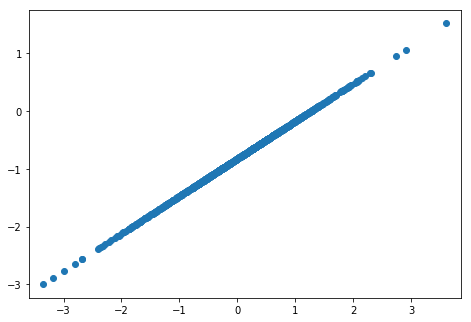

In [293]:
import toynn
import importlib
importlib.reload(toynn)

import torch
import torch.nn as tnn
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

DEVICE = 'cuda'

data_dim = 1
latent_dim = 1
n_layers = 1

decoder = toynn.Decoder(
    latent_dim=latent_dim, data_dim=data_dim, n_layers=n_layers)
decoder.to(DEVICE)

# Manually setting the initial weights
# decoder.d1.weight.data = torch.tensor([[1.]]).to(DEVICE)
# decoder.d1.bias.data = torch.tensor([0.]).to(DEVICE)

for name, param in decoder.named_parameters():
    print(name, param.data, '\n')
    
z, x = decoder.generate(n_samples=1000)

z = z.cpu().detach().numpy()
x = x.cpu().detach().numpy()

plt.figure()
fig = plt.figure()
ax = fig.add_axes([-1, 1, 1, 1])
ax.scatter(z, x)

chut = plt.axis('equal')

# Optimization investigation: 2D - FA

## Generating synthetic data from 2D model: x = wz +  eps for eps ~ N(0, psi)
## x in R^2, z in R

(2, 1)


(-5.578548934577017, 5.547706995793278, -9.279974773399186, 7.308271666204798)

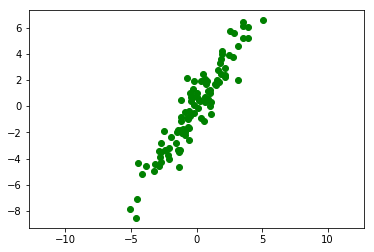

In [578]:
latent_dim = 1
data_dim = 2

# Models parameters
w_true = np.array([[2], [3]])
print(w_true.shape)
psi_true = np.diag([0.2, 0.8])

def generate_synthetic_2d(w=w_true, psi=psi_true, n=10):
    # Sample latent variable, noise -> generate data
    z = np.random.normal(loc=0, scale=1, size=(n, latent_dim))
    eps = np.random.multivariate_normal(mean=np.zeros(data_dim), cov=psi, size=n)
    # Generative model
    x = np.einsum('ij,nj->ni', w, z) + eps
    return z, x

n = 100
z, x = generate_synthetic_2d(n=n)

# Plot data
plt.scatter(x[:, 0], x[:, 1], color='green')
plt.axis('equal')

## Enter loglikelihood and other objectives, solve for extrema


In [595]:
phi2 = sp.symbols('phi2')
phi1 = sp.MatrixSymbol('phi1', 2, 1)
x_i = sp.MatrixSymbol('x_i', 2, 1)
w = sp.MatrixSymbol('w', 2, 1)
psi = sp.MatrixSymbol('psi', 2, 2)

x_cov = sp.MatMul(w, w.T) + psi
z_posterior_var = 1. / sp.MatMul(sp.MatMul(w.T, sp.Inverse(psi)), w)[0, 0]

ll_cst = - 1. / 2. * sp.log(2 * sp.pi)
ll_det = - 1. / 2. * sp.log(sp.det(x_cov))
ll_var = - 1. / 2. * sp.MatMul(sp.MatMul(x_i.T, sp.Inverse(x_cov)), x_i)

loglikelihood_i = ll_cst + ll_det + ll_var[0, 0]

kl_cst = - 1. /2.
kl_det = 1. / 2. * sp.log(z_posterior_var / phi2 ** 2)
kl_frac = (phi2 ** 2 + (z_posterior_var * sp.MatMul(w.T, x_i) - sp.MatMul(phi1.T, x_i))[0, 0] ** 2) / (2 * z_posterior_var)
klposterior_i =  kl_cst + kl_det + kl_frac
elbo_i = loglikelihood_i - klposterior_i

log_likelihood = np.mean([loglikelihood_i.subs(x_i, x_elmt) for x_elmt in x])
klposterior = np.mean([klposterior_i.subs(x_i, x_elmt) for x_elmt in x])
elbo = np.mean([elbo_i.subs(x_i, x_elmt) for x_elmt in x])